# Linear Programming and solving in Julia

In this notebook, emphasis is placed on linear programming and how to solve such optimization problems using Julia. 

We first give a very compact and high-level introduction to linear programming, while we then dive into a number of example problems that can formulated as linear program. We go from a text-based description of those problems, to their mathematical formulation, and finally to their solving with Julia.

There are a number of packages that are needed to be installed in Julia first:


In [1]:
using Pkg

Pkg.add("LinearAlgebra")    #Analogous to numpy package in Python
Pkg.add("Plots")    #Add Plots.jl framework for plotting
Pkg.add("JuMP")     #Add mathematical optimization package
Pkg.add("GLPK")     #Add solver
Pkg.add("IJulia")   #Backend for Jupyter interactive environment
Pkg.add("PyPlot")   #Julia interface to matplotlib.pyplot in Python

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`



## 1. Introduction to Linear Programming

A Linear Program (LP) is an optimization problem where the *objective function is linear* (in the decision variables), and subject to *linear equality and inequality constraints* (of the decision variables). An LP can always be written as a minimization or as a maximization problem. And, in principle, LPs can have a mix of all types of constraints, i.e., equality and two forms of inequalities (greater than or equal to, less than or equal to).

In its standard from though, an LP is written as a maximization problem, and with equality constraints only. Also, decision variables are to be non-negative. There are a number of tricks that can be used to reformulate any LP into its standard form (not covered here). Linear programs in standard form can be readily solved by hand by using the simplex method, while a wealth of solvers also exist which be used in your favourite programming language, e.g., R, Python and Julia. Typically, those programming languages allow to formulate optimization problems in algebraic form, i.e., they do not need to be formulated into their standard form. Here, we focus on using Julia for the solving of linear programs, since Julia is to be used all along the course. 

We therefore formulate LPs in their most general form here. Write $\mathbf{x}= [x_1, \, x_2, \, \ldots, \, x_n ]^\top$, $\mathbf{x} \in \mathbb{R}^n$, a vector of $n$ decision variables and $\mathbf{c}= [c_1, \, c_2, \, \ldots, \, c_n ]^\top$, $\mathbf{c} \in \mathbb{R}^n$, the unit cost vector associated to those variables. In parallel, define $A_\text{eq} \in \mathbb{R}^{m_\text{e} \times n}$ the matrix gathering the coefficients for the $m_\text{e}$ linear equality constraints for the $n$ decision variables, $A_\text{ineq} \in \mathbb{R}^{m_\text{i} \times n}$ the matrix gathering the coefficients for the $m_\text{i}$ linear inequality constraints for the $n$ decision variables, and finally $\mathbf{b}_\text{eq} \in \mathbb{R}^{m_\text{e}}$ and $\mathbf{b}_\text{ineq} \in \mathbb{R}^{m_\text{i}}$ the corresponding right-hand side for equality and inequality constraints, respectively. An LP in general algebraic form eventually writes

$$
\begin{align} \label{eq:lp}
\max_{\mathbf{x}} \quad  & \mathbf{c}^\top \mathbf{x} \nonumber \\
\text{s.t.} \quad & A_\text{eq} \mathbf{x} = \mathbf{b}_\text{eq} \nonumber \\
                  & A_\text{ineq} \mathbf{x} \leq \mathbf{b}_\text{ineq} \nonumber
\end{align}
$$

Any proposal solution for $\mathbf{x}$ is said *feasible* if it fulfills the constraints of the problem. That proposal solution is said *optimal* if it is that, among all feasible solution, which leads the highest value of the objective function. Since linear programs are a type of convex optimization problems, they inherit nice properties and results from convex optimization. For instance, if the feasibility set is closed and not empty, an optimal solution exists.




## 2. Example 1: Optimizing the diet of your cat

Many problems in our daily lives can be expressed as optimization problems, and in a linear programming form. Assume you have a cat as pet at home. Your aim clearly is to make sure that your cat has a healthy and balanced diet, while you also want to not overpay for it. Let us see how to focus on that problem and solve it.

### 2.1 Problem setup and formulation

For your cat, there are basically 2 types of food you can get from the supermarket: kibble (the hard and crunchy bites) and wet cat food (those small chunks in sauce or jelly). There are clearly differences in the nutrients in these two different food types, while their cost is different too. Emphasis is placed here on the contents in terms of fat, proteins and vitamins (in g equivalent, per kg). The characteristics of these food types, as well as cost (in DKK/kg) are gathered below:
 
| food type | fat | proteins | vitamins | price [DKK/kg] |
| --- | --- | --- | --- | --- |
| kibble | 100 | 10 | 50 | 50 |
| wet cat food | 150 | 40 | 10 | 90 |

The daily minimum requirements for your cat in terms of proteins and vitamins are of 20g and 10g, respectively. On the fat side though, one should not go beyond a daily intake of 100g. What quantity of kibble and wet cat food should you give to your cat, in order to meet those requirements while minimizing costs?

Let us write $x_1$ the quantity of kibble and $x_2$ the quantity of wet cat food. The objective function relates to the daily cost for the cat food. It can can readily be deduced based on unit prices and quantities, i.e., $50 x_1 + 90 x_2$. In parallel, the fat intake being less than 100g translates to

$$100 x_1 + 150 x_2 \leq 100$$

While the minimum intake for proteins and vitamins can be formulated as

$$
10 x_1 + 40 x_2 \geq 20 \\
50 x_1 + 10 x_2 \geq 10  \nonumber \\
$$

Finally, one should not forget that the quantities are necessarily non-negatice, i.e., $x_1,x_2 \geq 0$.

The resulting linear program writes

$$
\begin{align} 
\min_{x_1,x_2} \quad  & 50 x_1 + 90 x_2 \nonumber \\
\text{s.t.} \quad & 100 x_1 + 150 x_2 \leq 100  \nonumber \\
                  & 10 x_1 + 40 x_2 \geq 20  \nonumber \\
                  & 50 x_1 + 10 x_2 \geq 10  \nonumber \\
                  & x_1, x_2 \geq 0 \nonumber 
\end{align}
$$



### 2.2 Solving in Julia with JuMP and GPLK

It is actually fairly straightforward to formulate and solve a problem like that in the above in Julia, while the resulting formulation is very intuitive. After importing the necessary packages, one needs to declare the model and optimizer, define the parameters, decision variables, constraints and objective function. Finally one runs the optimization.

Here is the resulting piece of code in Julia:

In [2]:
#Import necessary Julia packages
using LinearAlgebra
using JuMP
using GLPK

#Declare model and optimizer
catmodel = Model()
set_optimizer(catmodel, GLPK.Optimizer)

#Define parameters
cv = [50.0,90.0]

#Define variables
@variable(catmodel, x[1:2])

#Define Constraints
@constraint(catmodel, 100*x[1] + 150*x[2] <= 100)
@constraint(catmodel, 10*x[1] + 40*x[2] >= 20)
@constraint(catmodel, 50*x[1] + 10*x[2] >= 10)
@constraint(catmodel, [i=1:2], x[i] >= 0)

#Define Objective
@objective(catmodel, Min, cv[1]*x[1] + cv[2]*x[2])

#Run the opimization
optimize!(catmodel)


Since the decision variables are gathered in the vector $\mathbf{x}=[x_1 \, \, x_2]$, one can then inquire for their value at optimality, after solving the problem:

In [3]:
value.(x)

2-element Vector{Float64}:
 0.10526315789473685
 0.47368421052631576

This then means that your decision regarding optimal quantities are 105g of kibble and 474g of wet cat food.

The related cost is readily given by the value of the objective function at optimality, i.e.

In [4]:
objective_value(catmodel)

47.89473684210526

So, by giving those quantities of food to your cat, you respect the dietary constraints, while reaching the minimum possible daily cost of 47.89 DKK per day.

### 3. Example 2: Energy storage arbitrage problem

The above problem was a very simple illustrative one, and you may argue that you do not need to use optimization (and linear programming) to decide which food and quantities to give to your cat. 

Let us now focus on a more advanced problem, for which one would clearly use optimization to make optimal decisions. With the green transition, we wee more renewable energy generation capacities (wind farms and solar power plants) out there, motivating the increasing use of energy storage. With the liberalization of electricity markets, storage assets can generate revenues based on adequate operation strategies.

### 3.1 Problem setup and formulation

Imagine being the operator of an energy storage asset in electricity markets (e.g., a large battery) aiming to optimize the use of the storage device over the coming period with $n$ time steps. This optimal operation in a liberalized electricity market environment translates to performing arbitrage -- sell when the price is high, buy when the price is low. The related optimization problem relies on a set of exogenous conditions, i.e. the set of future electricity prices $\mathbf{p}= [p_1, \, p_2, \, \ldots, \, p_n ]^\top, \mathbf{p}\in \mathbb{R}^n$. The battery has a nominal capacity $E_{\text{max}}$, charging efficiency $\eta_\text{c}$ and discharging efficiency $\eta_\text{d}$, as well as maximum charging and discharging rates $\bar{c}$ and $\bar{d}$, respectively.

Write $\mathbf{c}= [c_1, \, c_2, \, \ldots, \, c_n ]^\top, \mathbf{c} \in \mathbb{R}^n$, and $\mathbf{d}= [d_1, \, d_2, \, \ldots, \, d_n ]^\top, \mathbf{d} \in \mathbb{R}^n$, the two vectors of $n$ decision variables, where those decisions are for the future charging and discharging decisions. We additionally employ a auxiliary (decision) variable $\tau_i$ to denote the state of charge of the battery at time step $i$. This variable is used to describe the evolution of the state of charge of the battery at each and every time step $i$, i.e.,

$$ \tau_i = \tau_{i-1}+ \eta_c c_i - \eta_d d_i$$

The other constraints are fairly straightforward to implement. The objective of the operator of the energy storage asset is maximize revenues, as the difference of the revenue obtained when selling and the cost incurred when buying. Note that charging and discharging are mutually exclusive. Though, we do not need to use binary variables to impose such a condition. The objective eventually reads

$$p_i (d_i - c_i) $$

And finally, the storage arbitrage problem can be formulated as an LP, as

$$
\begin{align}
\max_{\mathbf{x}} \quad & \sum_{i=1}^n p_i (d_i - c_i)  \nonumber \\
\text{s.t.} \quad       & \tau_i = \tau_{i-1}+ \eta_c c_i - \eta_d d_i, && i=1, \ldots, n \nonumber \\
                        & \tau_i \leq E_{\text{max}}, &&  i=1, \ldots, n \nonumber \\
                        & \tau_0 = \tau_\text{i} \nonumber \\
                        & \tau_n \geq \tau_\text{e} \nonumber \\
                        & c_i \leq \bar{c}, && i=1, \ldots, n \nonumber \\
                        & d_i \leq \bar{d}, && i=1, \ldots, n \nonumber \\
                        & c_i, \, d_i \geq 0, && i=1, \ldots, 2n \nonumber
\end{align}
$$

A few parameters appeared in the above problem, i.e., $\tau_\text{i}$ the initial state of charge of the battery (seen as initial boundary condition) and $\tau_\text{e}$ the minimum target state of charge at the end of the period. 



### 3.2 Solving in Julia with JuMP and GPLK

We look here at a specific instance of the storage arbitrage problem described in the above. The storage asset has a capacity $E_\text{max}$ of 240 MWh, charging and discharging efficiencies of 0.9, as well as ramping rates of 120MW (both charging and discharging). The problem is for 6 consecutive time steps, with an initial state of charge of 70MWh and a minimum required state of charge at the end of the period of 80MWh. The electricity prices (in Euros/MWh) for those future times are supposed to be known, gathered in the following vector

$$[0.5, \, 1.4, \, 4.4, \, 9.4, \, 6.4, \, 2.3]$$

Here is how to solve that problem in Julia:

In [5]:
#Import necessary Julia Packages
using LinearAlgebra
using JuMP
using GLPK
using Plots

#Declare model and solver
storagemodel = Model()
set_optimizer(storagemodel, GLPK.Optimizer)

#Define parameters
n = 6
p = [0.5, 1.4, 4.4, 9.4, 6.4, 2.3]
Em = 240
η_c = 0.9
η_d = 0.9
cm = 120
dm = 120
τ_i = 70
τ_e = 80

#Define variables
@variable(storagemodel, cc[1:n])
@variable(storagemodel, dd[1:n])
@variable(storagemodel, τ[1:(n+1)])

#Define Constraints
@constraint(storagemodel, τ[1] == τ_i)
@constraint(storagemodel, [i=1:n], τ[i+1] == τ[i] + η_c*cc[i] - dd[i]/η_d)
@constraint(storagemodel, τ[n+1] >= τ_e)
@constraint(storagemodel, [i=2:(n+1)], τ[i] <= Em)
@constraint(storagemodel, [i=1:n], cc[i] <= cm)
@constraint(storagemodel, [i=1:n], dd[i] <= dm)
@constraint(storagemodel, [i=1:n], cc[i] >= 0)
@constraint(storagemodel, [i=1:n], dd[i] >= 0)
@constraint(storagemodel, [i=2:n], τ[i] >= 0)

#Define Objective
@objective(storagemodel, Max, sum(p[i]*(dd[i]-cc[i]) for i in 1:n))

#Run the opimization
optimize!(storagemodel)


There are now a number of decision variables we would like to visualize. Let us first look at charging and discharging decisions:

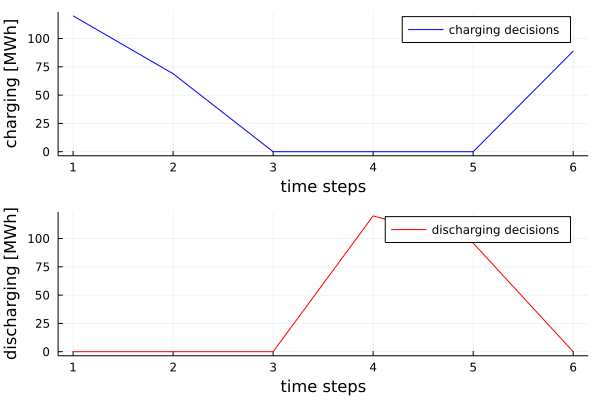

In [6]:
p1 = plot(1:6,value.(cc),color="blue",labels = "charging decisions")
xlabel!("time steps")
ylabel!("charging [MWh]")
p2 = plot(1:6,value.(dd),color="red",labels = "discharging decisions")
xlabel!("time steps")
ylabel!("discharging [MWh]")
plot(p1,p2,layout=(2,1))


We may also want to get the values for those charging and discharging decisions:

In [7]:
value.(cc)


6-element Vector{Float64}:
 120.0
  68.8888888888889
   0.0
   0.0
   0.0
  88.88888888888889

In [8]:
value.(dd)

6-element Vector{Float64}:
   0.0
   0.0
   0.0
 120.0
  95.99999999999999
   0.0

We may also want to visualize the evolution of the state of charge $\tau$ of the battery through the period:

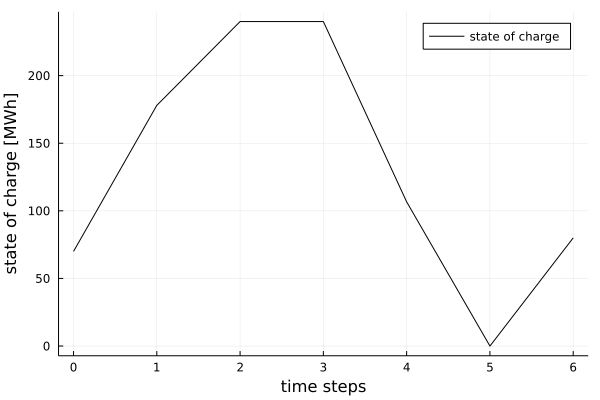

In [9]:
p1 = plot(0:6,value.(τ),color="black",labels = "state of charge")
xlabel!("time steps")
ylabel!("state of charge [MWh]")

Finally, the revenue of the operator of the energy storage asset (in Euros), for that period, is of 

In [10]:
objective_value(storagemodel)

1381.511111111111